In [1]:
TARGET_VARIABLE = "isPA"

# possibilities for the target variables are 
# isPA, isRPO, off_form, rec_form, playType, passCov, runConcept, off_scs


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import os

In [3]:
import math
import torch
import torch.nn as nn
from torch.nn import TransformerEncoder, TransformerEncoderLayer

class CNN_Transformer_Model(nn.Module):
    def __init__(self, input_size=9216, d_model=512, nhead=8, num_layers=2, 
                 dim_feedforward=2048, num_classes=2, dropout=0.1):
        super().__init__()
        
        # CNN feature extractor (same as before)
        self.cnn = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        
        # Transformer components
        self.feature_projection = nn.Linear(input_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, dim_feedforward, 
                                                dropout, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, num_layers)
        self.fc = nn.Linear(d_model, num_classes)

    def forward(self, x, src_key_padding_mask=None):
        batch_size, seq_len, channels, height, width = x.size()
        cnn_features = []
        
        # Process each frame through CNN
        for i in range(seq_len):
            frame_features = self.cnn(x[:, i]).flatten(1)
            cnn_features.append(frame_features)
            
        cnn_features = torch.stack(cnn_features, dim=1)
        projected_features = self.feature_projection(cnn_features)
        transformer_input = self.positional_encoding(projected_features)
        
        # Transformer with mask
        transformer_output = self.transformer_encoder(
            transformer_input, 
            src_key_padding_mask=src_key_padding_mask
        )
        
        pooled_output = transformer_output.mean(dim=1)
        return self.fc(pooled_output)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        # Corrected positional encoding calculation
        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(1)]  # Add positional encoding to sequence
        return self.dropout(x)

In [4]:
import torch
from torch.utils.data import Dataset
import pandas as pd
import numpy as np

class SequentialImageDataset(Dataset):
    def __init__(self, image_pickle, label_pickle, transform=None):
        self.transform = transform

        self.frames = pd.read_pickle(image_pickle)
        self.labels = pd.read_pickle(label_pickle)
        self.game_plays = np.unique(self.labels['game_play'])
        self.encoded_labels = self.labels.groupby('game_play')[TARGET_VARIABLE].first().to_dict()

    def __len__(self):
        return len(self.game_plays)

    def __getitem__(self, idx):
        gp = self.game_plays[idx]
        gp_frames = self.frames[self.frames['game_play'] == gp]

        sequence = []
        frame_nums = sorted(gp_frames['frameId'].unique())

        for frame_num in frame_nums:
            frame_data = gp_frames[gp_frames['frameId'] == frame_num]
            frame_matrix = np.zeros((100, 100), dtype='float32')

            for _, row in frame_data.iterrows():
                x, y, val = int(row['col_norm']), int(row['row_idx']), row['pos_id']
                if 0 <= x < 100 and 0 <= y < 100:
                    frame_matrix[y, x] = val

            if self.transform:
                frame_matrix = self.transform(frame_matrix)
            sequence.append(frame_matrix)

        sequence = np.array(sequence)
        sequence = np.expand_dims(sequence, axis=1)  # Shape: [seq_length, channels, H, W]
        
        label = self.encoded_labels[gp]

        # label_pa = self.labels[self.labels['game_play'] == gp][TARGET_VARIABLE].iloc[0]
        return torch.tensor(sequence), torch.tensor(label, dtype=torch.long)

In [7]:
# Dataset and DataLoader
image_train = './splits/tracking_processed_train.pkl'
label_train = './splits/label_processed_train.pkl'

In [8]:
from collections import Counter
from sklearn.preprocessing import LabelEncoder
import joblib  # Install with `pip install joblib`
from sklearn.utils import resample


# Load and encode labels BEFORE creating dataset
raw_labels = pd.read_pickle(label_train)
label_encoder = LabelEncoder()

# Create mapping: game_play -> encoded label
encoded_labels = raw_labels.groupby('game_play')[TARGET_VARIABLE].first()
encoded_labels = label_encoder.fit_transform(encoded_labels)

# Create label mapping dictionary
label_mapping = dict(zip(raw_labels['game_play'].unique(), encoded_labels))

# Create dataset with encoded labels
dataset_train = SequentialImageDataset(
    image_pickle=image_train,
    label_pickle=label_train,
    transform=None
)

# Inject the pre-encoded labels
dataset_train.encoded_labels = label_mapping

# Save encoder
joblib.dump(label_encoder, f'label_encoder_{TARGET_VARIABLE}.pkl')


# Count class occurrences
import numpy as np
from sklearn.utils import resample

# Get true class distribution from the dataset's encoded_labels
game_plays = dataset_train.game_plays  # Sorted unique game_plays
true_labels = np.array([dataset_train.encoded_labels[gp] for gp in game_plays])

# Calculate class counts and max count
unique_classes, class_counts = np.unique(true_labels, return_counts=True)
max_count = np.max(class_counts)

# Create balanced indices aligned with game_plays order
balanced_indices = []
for cls in unique_classes:
    # Get indices in game_plays order where class == cls
    cls_mask = (true_labels == cls)
    cls_indices = np.where(cls_mask)[0]
    
    # Resample to max_count
    resampled = resample(cls_indices,
                         replace=True,
                         n_samples=max_count,
                         random_state=42)
    balanced_indices.extend(resampled)

balanced_subset = torch.utils.data.Subset(dataset_train, balanced_indices)


# Custom collate function to pad sequences to the same length
def collate_fn(batch):
    sequences, labels = zip(*batch)
    lengths = [seq.shape[0] for seq in sequences]
    max_length = max(lengths)
    
    # Initialize padded tensor and mask
    padded_sequences = torch.zeros(len(sequences), max_length, *sequences[0].shape[1:])
    src_key_padding_mask = torch.zeros(len(sequences), max_length, dtype=torch.bool)
    
    for i, seq in enumerate(sequences):
        seq_length = lengths[i]
        padded_sequences[i, :seq_length] = seq
        if seq_length < max_length:
            src_key_padding_mask[i, seq_length:] = True  # Mask padding positions
            
    return padded_sequences, torch.stack(labels), src_key_padding_mask


Balanced Subset Verification (isPA)
Total samples: 21332
Number of classes: 2

Class               Count     Percentage     Deviation from Ideal
0                   10666     50.00%               +0.0 (+0.0%)
1                   10666     50.00%               +0.0 (+0.0%)

Quality Metrics:
Max-Min Ratio: 1.00:1
Standard Deviation: 0.0
Coefficient of Variation: 0.0%
Ideal Count: 10666.0

Statistical Test:
Chi-squared p-value: 1.0000 (Balanced)


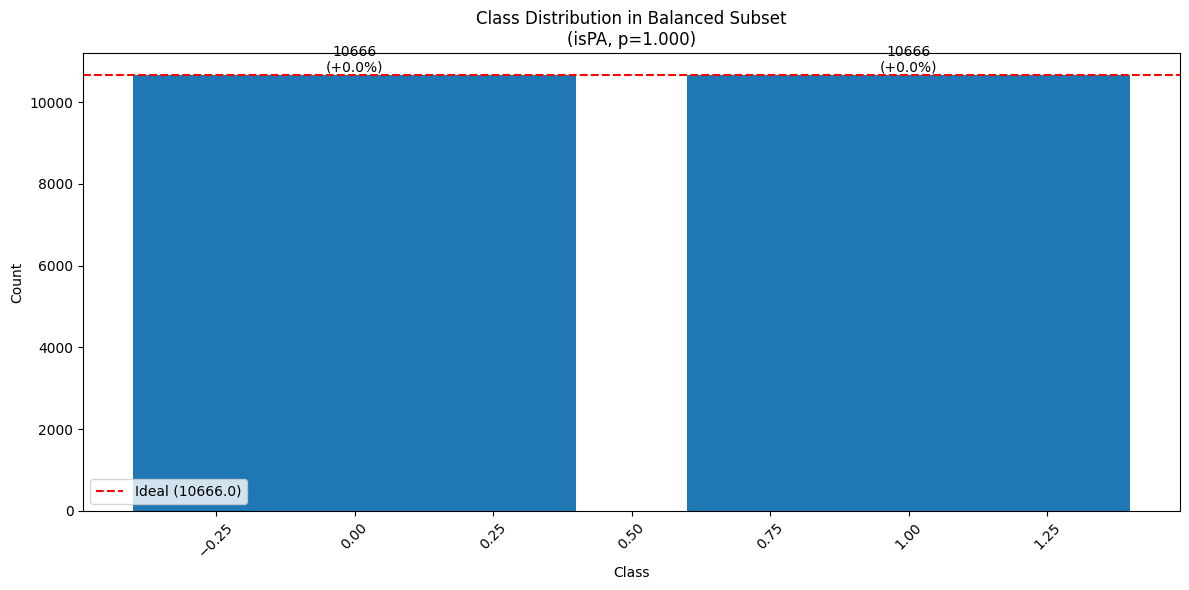


Index Integrity Checks:
Unique indices: 8867/21332
Max index: 12845 (Dataset size: 12847)


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

# Get actual labels from the balanced subset
subset_labels = [balanced_subset.dataset.encoded_labels[balanced_subset.dataset.game_plays[idx]] 
                for idx in balanced_subset.indices]

# Convert to class names using label encoder
class_names = label_encoder.classes_
subset_class_names = label_encoder.inverse_transform(subset_labels)

# 1. Class Distribution Analysis
class_counts = Counter(subset_class_names)
total_samples = len(balanced_subset)
num_classes = len(class_counts)

print("="*50)
print(f"Balanced Subset Verification ({TARGET_VARIABLE})")
print("="*50)
print(f"Total samples: {total_samples}")
print(f"Number of classes: {num_classes}\n")

# Print class distribution with multiple metrics
print(f"{'Class':<20}{'Count':<10}{'Percentage':<15}{'Deviation from Ideal':<20}")
ideal_count = total_samples / num_classes
for cls, count in class_counts.items():
    deviation = count - ideal_count
    print(f"{cls:<20}{count:<10}{count/total_samples:<15.2%}{deviation:>+10.1f} ({deviation/ideal_count:+.1%})")

# 2. Statistical Validation
count_values = np.array(list(class_counts.values()))
max_count = count_values.max()
min_count = count_values.min()
std_dev = count_values.std()
cov = std_dev / count_values.mean()

print("\nQuality Metrics:")
print(f"Max-Min Ratio: {max_count/min_count:.2f}:1")
print(f"Standard Deviation: {std_dev:.1f}")
print(f"Coefficient of Variation: {cov:.1%}")
print(f"Ideal Count: {ideal_count:.1f}")

# 3. Chi-Squared Test for Uniformity
from scipy.stats import chisquare
chi2, p_value = chisquare(count_values)
print(f"\nStatistical Test:")
print(f"Chi-squared p-value: {p_value:.4f} ({'Balanced' if p_value > 0.05 else 'Imbalanced'})")

# 4. Visual Verification
plt.figure(figsize=(12, 6))
bars = plt.bar(class_names, count_values)
plt.axhline(ideal_count, color='r', linestyle='--', label=f'Ideal ({ideal_count:.1f})')
plt.title(f"Class Distribution in Balanced Subset\n({TARGET_VARIABLE}, p={p_value:.3f})")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend()

# Add value labels with percentage deviation
for bar in bars:
    height = bar.get_height()
    deviation = (height - ideal_count)/ideal_count
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f"{height}\n({deviation:+.1%})",
             ha='center', va='bottom')

plt.tight_layout()
plt.show()

# 5. Index Sanity Checks
print("\nIndex Integrity Checks:")
# Check for duplicate indices
unique_indices = len(np.unique(balanced_subset.indices))
print(f"Unique indices: {unique_indices}/{len(balanced_subset.indices)}")

# Validate index range
max_index = max(balanced_subset.indices)
print(f"Max index: {max_index} (Dataset size: {len(balanced_subset.dataset)})")

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution(original_counts, balanced_counts, filename=f'class_distribution_{TARGET_VARIABLE}.png'):
    classes = list(original_counts.keys())
    x = np.arange(len(classes))
    width = 0.35

    fig, ax = plt.subplots(figsize=(10, 6))
    
    # Original distribution
    rects1 = ax.bar(x - width/2, [original_counts[c] for c in classes], 
                   width, label='Original', color='skyblue')
    # Balanced distribution
    rects2 = ax.bar(x + width/2, [balanced_counts[c] for c in classes], 
                   width, label='Balanced', color='salmon')

    ax.set_xlabel('Class')
    ax.set_ylabel('Number of Samples')
    ax.set_title(f'Class Distribution Before and After Balancing {TARGET_VARIABLE}')
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.legend()

    # Add exact counts on top of bars
    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

# Get balanced labels
balanced_labels = encoded_labels[balanced_indices]

# Count classes in balanced subset
balanced_counts = Counter(balanced_labels)

# Create and save plot
plot_class_distribution(class_counts, balanced_counts)

print(f"Class distribution plot saved as class_distribution_{TARGET_VARIABLE}.png")

Class distribution plot saved as class_distribution_isPA.png


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm
import os

# Assume the model and dataset are defined/imported from previous cells
# from model import CNN_LSTM_PA_Model
# from dataset import SequentialImageDataset

# Checkpoint directory
CHECKPOINT_DIR = "checkpoints"
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

def checkpoint(model, optimizer, filename):
    torch.save({
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
    }, os.path.join(CHECKPOINT_DIR, filename))

def model_resume(model, optimizer, filename):
    ckpt = torch.load(os.path.join(CHECKPOINT_DIR, filename))
    model.load_state_dict(ckpt['model'])
    optimizer.load_state_dict(ckpt['optimizer'])

# Check CUDA availability first
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Number of GPUs: {torch.cuda.device_count()}")

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


labels = encoded_labels

# Get number of classes dynamically
num_classes = len(np.unique(labels))
print(f"Number of classes: {num_classes}")

# Model initialization
model = CNN_Transformer_Model(
    input_size=9216,        # Must match CNN output features (64*12*12=9216)
    d_model=512,            # Transformer dimension
    nhead=8,                # Number of attention heads
    num_layers=2,           # Number of transformer layers
    dim_feedforward=2048,   # Feedforward dimension
    num_classes=num_classes,             # Number of classes
    dropout=0.1
)

# Multi-GPU setup
if torch.cuda.is_available():
    if torch.cuda.device_count() > 1:
        print(f"Using {torch.cuda.device_count()} GPUs with DataParallel!")
        model = nn.DataParallel(model)
    # Move model to device AFTER DataParallel wrapping
    model = model.to(device)
    torch.backends.cudnn.benchmark = True
else:
    print("Warning: Training on CPU - CUDA not available")
    

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Use the existing train_loader that has the custom collate function
# Remove the incorrect DataLoader redefinition:

# First create the balanced subset


# Then create the DataLoader with both balancing and proper collate
train_loader = DataLoader(
    balanced_subset,
    batch_size=5,  # Increased from 1
    shuffle=True,
    num_workers=128,  # Reduced from 64
    persistent_workers=True,
    pin_memory=True,
    collate_fn=collate_fn
)

# Remove any other DataLoader definitions (e.g., this one):

# Training parameters
num_epochs = 10
loss_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}")
    
    for padded_sequences, labels, padding_mask in pbar:
        inputs = padded_sequences.to(device)
        
        labels = labels.to(device)
        mask = padding_mask.to(device)
        optimizer.zero_grad()
        outputs = model(inputs, src_key_padding_mask=mask)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        pbar.set_postfix(loss=running_loss / (pbar.n + 1))

    epoch_loss = running_loss / len(train_loader)
    loss_history.append(epoch_loss)

    print(f"Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f}")

    checkpoint(model, optimizer, f'epoch-{epoch}.pth')



CUDA available: True
Number of GPUs: 4
Number of classes: 2
Using 4 GPUs with DataParallel!


Epoch 1/10:   0%|          | 0/4267 [00:00<?, ?it/s]

Epoch 1/10:  35%|███▍      | 1483/4267 [13:14<24:51,  1.87it/s, loss=0.72] 


KeyboardInterrupt: 

In [ ]:
train_loader = DataLoader(
    balanced_subset,
    batch_size=5,  # Increased from 1
    shuffle=True,
    num_workers=1,  # Reduced from 64
    persistent_workers=True,
    pin_memory=True,
    collate_fn=collate_fn
)





AttributeError: 'list' object has no attribute 'items'

In [20]:
for batch in train_loader:
    print(batch)
    break

[tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]],


         ...,


         [[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
    

In [31]:
batch[0].shape

torch.Size([5, 201, 1, 100, 100])

In [ ]:
batch[1]

tensor([0, 1, 1, 0, 0])

In [32]:
batch[2]

tensor([[False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ...,  True,  True,  True],
        [False, False, False,  ...,  True,  True,  True]])

Error during plotting: x and y must have same first dimension, but have shapes (10,) and (0,)


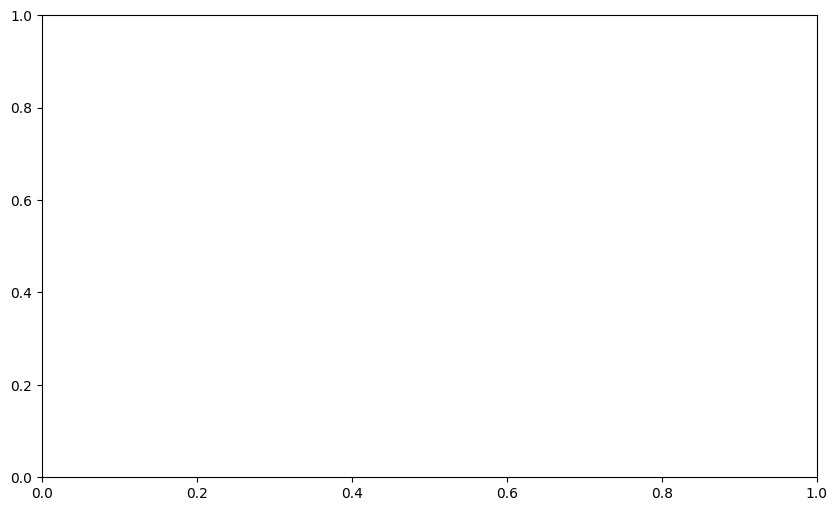

In [13]:
# Save final model
torch.save(model.state_dict(), f'CNN_TRANSFORMER_{TARGET_VARIABLE}_final.pth')

# Plot and save training loss
try:
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, num_epochs + 1), loss_history, marker='o', linestyle='-', color='b')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(f'Training Loss for Play Action ({TARGET_VARIABLE})) Prediction')
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    plt.savefig(f'training_loss_{TARGET_VARIABLE}.png', dpi=300, bbox_inches='tight')  # Save as high-res PNG
    plt.show()
except Exception as e:
    print(f"Error during plotting: {e}")

In [14]:
# First create test dataset and loader
image_test = './splits/tracking_processed_test.pkl'
label_test = './splits/label_processed_test.pkl'

# Load encoder
label_encoder = joblib.load(f'label_encoder_{TARGET_VARIABLE}.pkl')

# Prepare test dataset with encoded labels
raw_test_labels = pd.read_pickle(label_test)
test_game_plays = raw_test_labels['game_play'].unique()
encoded_test_labels = label_encoder.transform(
    raw_test_labels.groupby('game_play')[TARGET_VARIABLE].first()
)

dataset_test = SequentialImageDataset(
    image_pickle=image_test,
    label_pickle=label_test,
    transform=None
)
dataset_test.encoded_labels = dict(zip(test_game_plays, encoded_test_labels))


test_loader = DataLoader(
    dataset_test,
    batch_size=32,
    shuffle=False,
    num_workers=4,
    collate_fn=collate_fn
)

def evaluate_model(model, loader, device):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for padded_sequences, labels, padding_mask in tqdm(loader, desc="Evaluating"):
            inputs = padded_sequences.to(device)
            labels = labels.to(device)
            mask = padding_mask.to(device)
            
            outputs = model(inputs, src_key_padding_mask=mask)
            _, preds = torch.max(outputs, 1)
            
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return all_labels, all_preds

# Load best model (using final model in this case)
model.load_state_dict(torch.load(f'CNN_TRANSFORMER_{TARGET_VARIABLE}_final.pth'))
model = model.to(device)

# Run evaluation
true_labels, predictions = evaluate_model(model, test_loader, device)

# Metrics and visualization
from sklearn.metrics import (confusion_matrix, accuracy_score, 
                             classification_report, ConfusionMatrixDisplay)
import matplotlib.pyplot as plt
import seaborn as sns

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, classes, filename):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    
    fig, ax = plt.subplots(figsize=(8,6))
    disp.plot(ax=ax, cmap=plt.cm.Blues)
    plt.title("Confusion Matrix")
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()

# Metrics Summary
def plot_metrics_summary(y_true, y_pred, filename):
    report = classification_report(y_true, y_pred, output_dict=True)
    
    metrics = ['precision', 'recall', 'f1-score']
    classes = list(report.keys())[:-3]  # Exclude avg/total
    
    plt.figure(figsize=(10, 6))
    for cls in classes:
        values = [report[cls][metric] for metric in metrics]
        plt.plot(metrics, values, marker='o', label=cls)
    
    plt.title("Classification Metrics")
    plt.ylim(0, 1.1)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.close()



/tmp/ipykernel_12922/4222637066.py:51: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(f'CNN_TRANSFORMER_{TARGET_VARIABLE}_final.pth'))
Evalua

In [15]:
# Generate and save plots
# class_names = ['Non-PA', 'PA']  # Update with your actual class names
class_names = [str(cls) for cls in label_encoder.classes_]  # Dynamic class names from encoder
plot_confusion_matrix(true_labels, predictions, class_names, f'confusion_matrix_{TARGET_VARIABLE}.png')
plot_metrics_summary(true_labels, predictions, f'classification_metrics_{TARGET_VARIABLE}.png')

# Save numerical metrics
with open(f'test_metrics_{TARGET_VARIABLE}.txt', 'w') as f:
    f.write(f"Accuracy: {accuracy_score(true_labels, predictions):.4f}\n")
    f.write("Classification Report:\n")
    f.write(classification_report(true_labels, predictions, target_names=class_names))

print("Evaluation completed. Saved:")
print(f"- confusion_matrix{TARGET_VARIABLE}.png")
print("- classification_metrics{TARGET_VARIABLE}.png")
print(f"- test_metrics.txt")

Evaluation completed. Saved:
- confusion_matrixisPA.png
- classification_metrics{TARGET_VARIABLE}.png
- test_metrics.txt
